Some facts:
- infections with symptoms roughly 50% of all infections https://www.nature.com/articles/d41586-020-00822-x

In [23]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import re

## Building the data

In [226]:
tot_pops = {'Bayern': 13076721,
            'Schleswig-Holstein': 2896712,
            'Hamburg': 1841179,
            'Bremen': 82986,
            'Nordrhein-Westfalen': 17932651,
            'Hessen': 6265809,
            'Rheinland-Pfalz': 4084844,
            'Baden-Württemberg': 11069533,
            'Saarland': 990509,
            'Berlin': 3644826,
            'Mecklenburg-Vorpommern': 1609675,
            'Sachsen': 4077937,
            'Sachsen-Anhalt': 2208321,
            'Thüringen': 2143145,
            'Niedersachsen': 7963000,
            'Brandenburg': 2504000,
           }

Read aggregated data fro BL/age/sex

In [227]:
BL_df = pd.read_csv("daily_corona_data/aggregate_BL_G_AG.csv", index_col=0)
BL_df.Meldedatum = BL_df.Meldedatum.transform(lambda x: datetime.datetime.strptime(re.sub("T.*", "", x), "%Y-%m-%d"))
BL_df.head()

,Meldedatum,Bundesland,Geschlecht,Altersgruppe,AnzahlFall,AnzahlTodesfall,TotalAnzahl_BL_G_AG,TotalDeath_BL_G_AG
0,2020-01-28,Bayern,M,A15-A34,1,0,1,0
2,2020-01-29,Bayern,M,A15-A34,1,0,2,0
6,2020-02-03,Bayern,M,A15-A34,1,0,3,0
35,2020-02-28,Bayern,M,A15-A34,1,0,4,0
102,2020-03-03,Bayern,M,A15-A34,1,0,5,0


How many BL? How many age groups?

In [228]:
age_groups = BL_df.Altersgruppe.unique()
age_groups = age_groups[age_groups != "unbekannt"]
n_age_groups = len(age_groups)
age_groups

array(['A15-A34', 'A35-A59', 'A00-A04', 'A60-A79', 'A05-A14', 'A80+'],
      dtype=object)

In [229]:
lander = BL_df.Bundesland.unique()
lander = lander[lander != "-nicht erhoben-"]
n_lander = len(lander)
lander

array(['Bayern', 'Niedersachsen', 'Baden-Württemberg',
       'Nordrhein-Westfalen', 'Hessen', 'Rheinland-Pfalz',
       'Schleswig-Holstein', 'Hamburg', 'Brandenburg', 'Bremen',
       'Sachsen', 'Berlin', 'Mecklenburg-Vorpommern', 'Thüringen',
       'Saarland', 'Sachsen-Anhalt'], dtype=object)

Pick numbers from last week

In [230]:
today = BL_df.Meldedatum.sort_values().iloc[-1]
last_week = today - datetime.timedelta(days=7)
last_week

Timestamp('2020-03-13 00:00:00')

Let's use the following conventions:
age groups (as in paper):
    - 0 to 9
    - 10 to 19
    - 20 to 29
    - 30 to 39
    - 40 to 49
    - 50 to 59
    - 60 to 69
    - 70 to 79
    - 80+
and further compartementalize according to sex.

All rates are therefore given as 2D arrays of shape (9, 2) where the first axis is the age group and the second the gender.

In [231]:
#OD = np.random.randint(100,10000, (n_lander, n_lander, n_age_groups, 2))

In [232]:
#OD = OD.sum(axis=3).sum(axis=2)
# Fill matrix diagonally, no commuting between bundesländer
OD = np.zeros((n_lander, n_lander))
for idx, land in enumerate(lander):
    OD[idx ,idx] = tot_pops[land]

In [233]:
def split_groups(N):
    split_points = np.random.choice(range(1,N), n_age_groups-1, replace = False)
    split_points.sort()
    age_groups = [split_points[0]]+[split_points[n]-split_points[n-1] for n in range(1,len(split_points))] + [N-split_points[-1]]
    groups = [[np.random.choice(range(g), 1), g] for g in age_groups]
    groups = [[int(a[0]),int(a[1]-a[0])] for a in groups]
    return np.array(groups)

In [234]:
# initialize the population vector from the origin-destination flow matrix
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1)).astype(int)
locs_len = len(N_k)                      # number of locations
SIR = np.zeros(shape=(locs_len, n_age_groups, 2, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
for i in tqdm.tqdm_notebook(range(locs_len)):
    SIR[i,:,:,0] = split_groups(N_k[i])                      # initialize the S group with the respective populations

<ipython-input-234-00b7abc21024>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(locs_len)):


Retrieve first infections

In [235]:
for land_idx, land in enumerate(lander):
    for age_group_idx, age_group in enumerate(age_groups):
        for sex_idx, sex in enumerate(["M", "W"]):
            infected = BL_df[(BL_df.Meldedatum == last_week) & (BL_df.Bundesland == land) & (BL_df.Altersgruppe == age_group) & (BL_df.Geschlecht == sex)].TotalAnzahl_BL_G_AG
            if len(infected) > 0:
                infected = infected.iloc[0]
            else:
                infected = 0
            SIR[land_idx, age_group_idx, sex_idx, 1] = infected

Retrieve deaths and approximate recovered

In [236]:
for land_idx, land in enumerate(lander):
    for age_group_idx, age_group in enumerate(age_groups):
        for sex_idx, sex in enumerate(["M", "W"]):
            dead = BL_df[(BL_df.Meldedatum == last_week) & (BL_df.Bundesland == land) & (BL_df.Altersgruppe == age_group) & (BL_df.Geschlecht == sex)].TotalDeath_BL_G_AG
            if len(dead) > 0:
                recovered = 100 * dead.iloc[0]
            else:
                recovered = 0
            SIR[land_idx, age_group_idx, sex_idx, 2] = recovered

Compute susceptible

In [237]:
for land_idx, land in enumerate(lander):
    for age_group_idx, age_group in enumerate(age_groups):
        for sex_idx, sex in enumerate(["M", "W"]):
            SIR[land_idx, age_group_idx, sex_idx, 0] = SIR[land_idx, age_group_idx, sex_idx, 0] - SIR[land_idx, age_group_idx, sex_idx, 1]

In [238]:
#N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
#locs_len = len(N_k)                 # number of locations
#SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
#SIR[:,0] = N_k                      # initialize the S group with the respective populations
#
#first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
#SIR[:, 0] = SIR[:, 0] - first_infections
#SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group
#
## row normalize the SIR matrix for keeping track of group proportions
#row_sums = SIR.sum(axis=1)
#SIR_n = SIR / row_sums[:, np.newaxis]

In [239]:
# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=3).sum(axis=2).sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis, np.newaxis, np.newaxis]

### initialize parameters

In [240]:
beta = np.full((n_age_groups, 2), 0.16)
gamma = np.full((n_age_groups, 2), 0.04)
public_trans = [0.7]*4+[0.01]*60        # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(beta, 1/gamma, (locs_len, n_age_groups, 2))
#beta_vec = np.full((locs_len, n_age_groups, 2), R0)
gamma_vec = np.full((locs_len, n_age_groups, 2), gamma)
public_trans_vec = [np.full((locs_len, n_age_groups, 2), alpha) for alpha in public_trans]

In [241]:
R0

array([[4., 4.],
       [4., 4.],
       [4., 4.],
       [4., 4.],
       [4., 4.],
       [4., 4.]])

In [242]:
# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

In [243]:
# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []
n_days = 20
days = [last_week + datetime.timedelta(j) for j in range(n_days)]
days = [d.to_datetime64() for d in days]
for time_step in tqdm.tqdm_notebook(range(n_days)):
    infected_mat = np.array([SIR_nsim[:,:,:,1],]*locs_len)#.transpose()
    OD_infected = np.round(OD[:,:,np.newaxis, np.newaxis]*infected_mat)
    inflow_infected = OD_infected.sum(axis=1)
    inflow_infected = np.round(inflow_infected * public_trans_vec[time_step])
    print('total infected inflow: ', inflow_infected.sum())
    new_infect = beta_vec*SIR_sim[:,:,:, 0]*inflow_infected/(N_k + OD.sum(axis=0))[:,np.newaxis, np.newaxis]
    new_recovered = gamma_vec*SIR_sim[:,:,:, 1]
    new_infect = np.where(new_infect>SIR_sim[:,:,:, 0], SIR_sim[:,:,:, 0], new_infect)
    SIR_sim[:,:,:, 0] = SIR_sim[:,:,:, 0] - new_infect
    SIR_sim[:,:,:, 1] = SIR_sim[:,:,:, 1] + new_infect - new_recovered
    SIR_sim[:,:,:, 2] = SIR_sim[:,:,:, 2] + new_recovered
    SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
    # recompute the normalized SIR matrix
    row_sums = SIR_sim.sum(axis=3).sum(axis=2).sum(axis=1)
    SIR_nsim = SIR_sim / row_sums[:, np.newaxis, np.newaxis, np.newaxis]
    S = SIR_sim[:,:,:,0].sum()/N_k.sum()
    I = SIR_sim[:,:,:,1].sum()/N_k.sum()
    R = SIR_sim[:,:,:,2].sum()/N_k.sum()
    print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
    print('\n')
    infected_pop_norm.append(I)
    susceptible_pop_norm.append(S)
    recovered_pop_norm.append(R)

False


<ipython-input-243-674f7dbf5695>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_step in tqdm.tqdm_notebook(range(n_days)):


total infected inflow:  3216.0
0.9999395073653656 5.826231689714229e-05 2.529085159007478e-05 82393747.99999999 82391848


total infected inflow:  3362.0
0.9999269391381796 6.850005140722193e-05 2.7621344265960478e-05 82393748.00000001 82391848


total infected inflow:  3951.0
0.999888228277281 0.00010447091024973502 3.036134632224936e-05 82393748.00000001 82391848


total infected inflow:  6020.0
0.9997583065997485 0.00023021375137202718 3.4540182732238755e-05 82393747.99999999 82391848


total infected inflow:  179.0
0.9997516658683856 0.00022764593268002228 4.3748732787119845e-05 82393747.99999999 82391848


total infected inflow:  176.0
0.9997449794443184 0.00022522651944008944 5.2854570094320736e-05 82393748.00000001 82391848


total infected inflow:  174.0
0.9997382434802039 0.00022295342277694861 6.186363087192431e-05 82393747.99999999 82391848


total infected inflow:  173.0
0.9997315081982928 0.00022077056777699959 7.078176778300227e-05 82393748.00000001 82391848


total infec

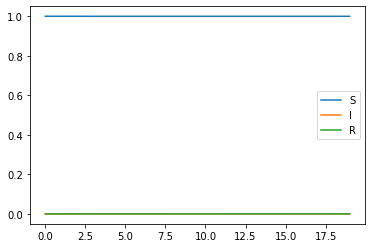

In [244]:
plt.plot(susceptible_pop_norm, label='S')
plt.plot(infected_pop_norm, label='I')
plt.plot(recovered_pop_norm, label='R')
plt.legend()

In [245]:
agg_df = BL_df.groupby("Meldedatum").sum()
last_week_df = agg_df[agg_df.index >= last_week]
last_week_df

,AnzahlFall,AnzahlTodesfall,TotalAnzahl_BL_G_AG,TotalDeath_BL_G_AG
Meldedatum,,,,
2020-03-13,1317,4,4610,19
2020-03-14,1179,2,5695,21
2020-03-15,837,2,6393,20
2020-03-16,1776,2,8380,25
2020-03-17,2519,5,10917,30
2020-03-18,2689,7,13513,37
2020-03-19,1983,6,13149,37
2020-03-20,964,4,12270,41


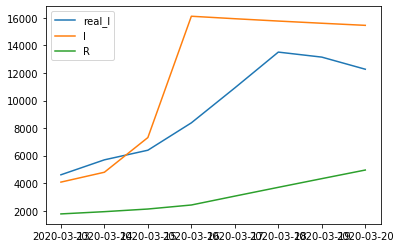

In [246]:
plt.plot(last_week_df.index, "TotalAnzahl_BL_G_AG", data=last_week_df, label="real_I")
plt.plot(np.array(days)[:8], np.array(infected_pop_norm)[:8] * 70000000, label='I')
plt.plot(np.array(days)[:8], np.array(recovered_pop_norm)[:8] * 70000000, label='R')
plt.legend()